In [1]:
import os

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(context='paper', style='white', font_scale=1.6, color_codes=True)

In [3]:
import jax.numpy as jnp
import equinox as eqx
import jax.tree_util as jtu
import numpyro

from numpyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, TraceMeanField_ELBO, Predictive
from copy import deepcopy
from math import prod
from jax import random, nn, vmap, devices, device_put, value_and_grad, lax

from bmr4pml.models import SVIRegression, BMRRegression
from bmr4pml.nn import MLP, LeNet
from bmr4pml.datasets import load_data
from bmr4pml.inference import fit_and_test

rng_key = random.PRNGKey(0)

In [4]:
def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def run_inference(rng_key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression):

    reg = reg_model(
        nnet,
        **opts_regression
    )

    rng_key, opts_fitting['key'] = random.split(rng_key)
    return fit_and_test(reg, train_ds, test_ds, opts_fitting)

def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.95, 1.])
    fig.tight_layout()

    return fig

In [5]:
from numpyro.optim import _NumPyroOptim
import optax

class _ParallelNumPyroOptim(_NumPyroOptim):
    def __init__(self, optim_fn, *args, **kwargs) -> None:
        super().__init__(optim_fn, *args, **kwargs)

    def eval_and_update(self, fn, state):
        """
        Performs an optimization step for the objective function `fn`.
        For most optimizers, the update is performed based on the gradient
        of the objective function w.r.t. the current state. However, for
        some optimizers such as :class:`Minimize`, the update is performed
        by reevaluating the function multiple times to get optimal
        parameters.

        :param fn: an objective function returning a pair where the first item
            is a scalar loss function to be differentiated and the second item
            is an auxiliary output.
        :param state: current optimizer state.
        :return: a pair of the output of objective function and the new optimizer state.
        """
        params = self.get_params(state)
        (loss, aux), grads = vmap(value_and_grad(fn, has_aux=True))(params)
        A = state[1][1].A
        n = state[1][1].noise
        N = state[1][1].N
        entropy = jtu.tree_map( lambda x: jnp.log(2 * jnp.pi * jnp.exp(1) * (n * x) ** 2).sum() / 2, A)
        FE = loss.mean() - jnp.stack(jtu.tree_flatten(entropy)[0]).sum() / N
        return (FE, aux), self.update(grads, state)

class BLRToNumpyro(object):

    def __call__(self, transformation) -> _ParallelNumPyroOptim:
        """
        This function produces a ``numpyro.optim._NumPyroOptim`` instance from an
        ``optax.GradientTransformation`` so that it can be used with
        ``numpyro.infer.svi.SVI``. It is a lightweight wrapper that recreates the
        ``(init_fn, update_fn, get_params_fn)`` interface defined by
        :mod:`jax.example_libraries.optimizers`.

        :param transformation: An ``optax.GradientTransformation`` instance to wrap.
        :return: An instance of ``numpyro.optim._NumPyroOptim`` wrapping the supplied
            Optax optimizer.
        """

        def init_fn(params):
            opt_state = transformation.init(params)
            return params, opt_state

        def update_fn(step, grads, state):
            params, opt_state = state
            updates, opt_state = transformation.update(grads, opt_state, params)
            updated_params = optax.apply_updates(params, updates)
            return updated_params, opt_state

        def get_params_fn(state):
            params, opt_state = state
            return jtu.tree_map(lambda x, s, e: x + s * e, params, opt_state.A, opt_state.ε)

        return _ParallelNumPyroOptim(lambda x, y, z: (x, y, z), init_fn, update_fn, get_params_fn)

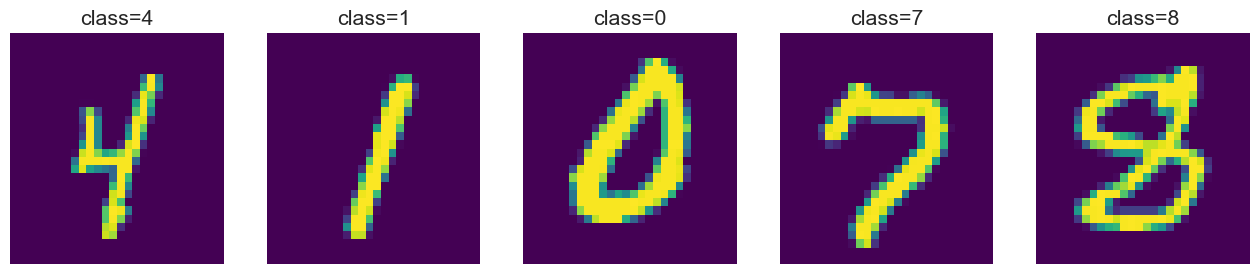

In [6]:
# load data
train_ds, test_ds = load_data('mnist', id=0)

in_size = train_ds['image'].shape[-3:]
out_size = len(jnp.unique(train_ds['label']))

fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharex=True, sharey=True)
for n in range(5):
    sns.heatmap(
        train_ds['image'][n].squeeze() / 255, 
        cmap='viridis', 
        ax = axes[n], 
        cbar=False, 
        vmax=1., 
        vmin=0.,
        xticklabels="",
        yticklabels=""
    )
    axes[n].set_title('class={}'.format(train_ds['label'][n]))

train_ds['image'], test_ds['image'] = standardize(train_ds['image'], test_ds['image'], num_channels=1)

In [7]:
import numpyro.distributions as dist

def init_fn(rng_key, shape, radius=2.):
    return random.uniform(rng_key, shape=shape, minval=-radius, maxval=radius)

def get_linear_layers(nnet):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear) or isinstance(x, eqx.nn.Conv) or isinstance(x, eqx.nn.LayerNorm)
    return [x for x in jtu.tree_leaves(nnet, is_leaf=is_linear) if is_linear(x)]

def register_network_params(nnet, mask, adaptive_scale=True):
    layers = get_linear_layers(nnet)
    L = len(layers)
    new_layers = []
    for l, layer in enumerate(layers):
        name = f'layer{l}'
        weight = layer.weight
        bias = layer.bias
        shape = weight.reshape(weight.shape[0], -1).shape
        if bias is not None:
            shape = (shape[0], shape[1] + 1)
        
        _scale = numpyro.param(f'{name}._scale', lambda key: init_fn(key, (1,), radius=1)) if adaptive_scale else 2.0
        if l == L - 1:
            scale = jnp.exp( - 0.32 * _scale + 0.65)
        else:
            scale = jnp.exp( - 0.32 * _scale + 0.65) / 10

        _weights = scale * numpyro.param(name, lambda key: init_fn(key, shape))

        _weights = jnp.where(mask[name], _weights, 0.) if mask is not None else _weights
        
        weight = _weights.reshape(weight.shape) if bias is None else _weights[..., :-1].reshape(weight.shape)
        bias = _weights[..., -1].reshape(bias.shape) if bias is not None else bias

        layer = eqx.tree_at(lambda x: (x.weight, x.bias), layer, (weight, bias))
        new_layers.append(layer)
    
    return eqx.tree_at(get_linear_layers, nnet, new_layers)

def likelihood(nnet, x, y, batch_size=None):
    N = x.shape[0]
    with numpyro.plate('data', N, subsample_size=batch_size):
        batch_x = numpyro.subsample(x, event_dim=3)
        key = random.PRNGKey(0) if numpyro.prng_key() is None else numpyro.prng_key()
        keys = random.split(key, batch_x.shape[0]) 
        logits = numpyro.deterministic('logits', vmap(nnet)(batch_x, key=keys) )

        batch_y = y if y is None else numpyro.subsample(y, event_dim=0)
        
        numpyro.deterministic('probs', nn.softmax(logits, -1))
        with numpyro.handlers.scale(scale=1/N):
            numpyro.sample('obs', dist.Categorical(logits=logits), obs=batch_y)

def model(nnet, x, y=None, batch_size=None, mask=None, adaptive_scale=True):

    nnet = register_network_params(nnet, mask, adaptive_scale=adaptive_scale)
    likelihood(nnet, x, y, batch_size)

def guide(*args, **kwargs):
    pass

In [8]:
from bmr4pml.inference import tests
from functools import partial

loss = Trace_ELBO()

def train_and_test_delta(optim, rng_key, num_epochs, num_iters, test_ds, *args, t_lam=None, N=1, prune=False, del_f=None, progress_bar=False, **kwargs):
    svi = SVI(model, guide, optim, loss)
    rng_key, key = random.split(rng_key)
    state = svi.init(key, *args, **kwargs)
    params = svi.get_params(state)
    mask = jtu.tree_map(lambda x: True, params)

    losses = []
    results = {'acc': [], 'ece': [], 'nll': [], 'lpd': []}
    det_nnet = eqx.tree_inference(args[0], value=True)

    for epoch in range(num_epochs):
        key, _key = random.split(key)
        kwargs = kwargs | {'mask': mask}
        svi_out = svi.run(
            _key, 
            num_iters,
            *args,
            progress_bar=progress_bar,
            init_state=state,
            init_params=params,
            ** kwargs 
        )

        state = svi_out.state
        params = svi_out.params
        losses.append( svi_out.losses )

        mdl = partial(numpyro.handlers.substitute(model, params), det_nnet, mask=mask)

        key, _key = random.split(key)
        smpl = Predictive(mdl, num_samples=1)(_key, test_ds['image'], y=test_ds['label'])
        smpl.pop('obs')
        
        output = tests(mdl, smpl, test_ds['image'], test_ds['label'])
        for label in results:
            results[label].append(output[label])
        
        if prune and epoch < num_epochs - 1:
            sigmas = jtu.tree_map( lambda x: 1 / jnp.sqrt( N * (x + t_lam) ), state.optim_state[1][1][0].s)
            mu = params
            mask = jtu.tree_map(lambda m, s, t: t * (del_f(m, s) <= 0), mu, sigmas, mask)

    results['losses'] = losses
    results['mask'] = mask

    return results, rng_key, params, state

# DenseNet

In [9]:
depth = 3
num_neurons = 100
num_epochs = 20
num_iters = 500

cpu = devices('cpu')[0]
results = {'dense': {}, 'lenet': {}}

In [10]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'autoguide': 'delta',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': num_iters,
    'num_samples': 1,
    'model_kwargs': {
        'batch_size': 128, 
        'with_hyperprior': False,
    }
}

rng_key, key = random.split(rng_key)
nnet = MLP( prod(in_size), out_size, num_neurons, depth, activation=nn.swish, dropout_rate=0.2, key=key)

In [ ]:
rng_key, key = random.split(rng_key)
output = run_inference(key, nnet, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-MAP'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 20/20 [07:08<00:00, 21.45s/it, init loss: 383938.2500, avg. loss [epoch 20]: 138579.2656]


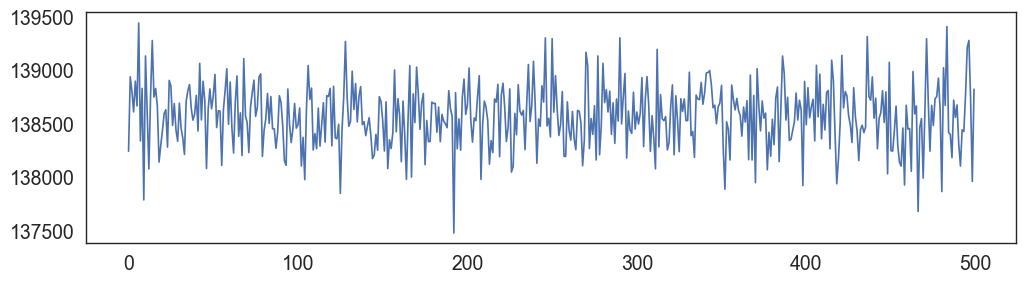

In [ ]:
opts_regression = opts_regression | {'autoguide': 'mean-field'}
opts_fitting = opts_fitting | {'num_samples': 100}

dense = eqx.tree_inference(nnet, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Flat-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

100%|██████████| 20/20 [08:57<00:00, 26.87s/it, init loss: 535315.7500, avg. loss [epoch 20]: 18591.4609]


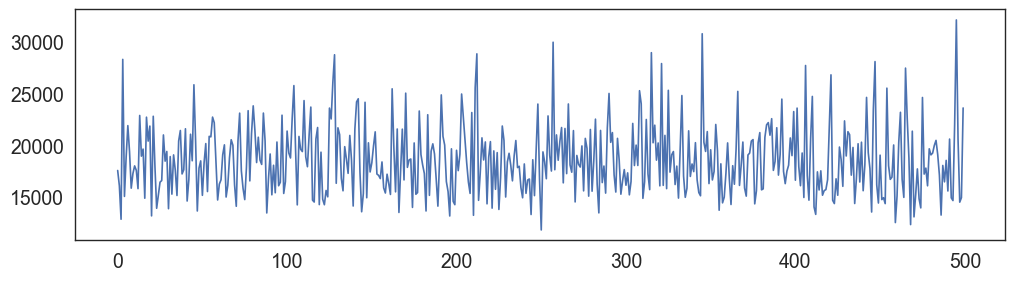

In [ ]:
opts_regression = opts_regression | {'tau0': 1e-2, 'reduced': True, 'autoguide': 'mean-field'}
opts_fitting = opts_fitting | {'num_samples': 100, 'model_kwargs': {'batch_size': 128, 'with_hyperprior': True}}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=SVIRegression)
results['dense']['Tiered-FF'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

In [ ]:
opts_regression = {
    'regtype': 'multinomial',
    'gamma0': 0.1,
    'pruning': 'spike-and-slab',
    'posterior': 'normal',
    'optim_kwargs': {
        'learning_rate': 1e-2
    }
}

opts_fitting = {
    'num_epochs': num_epochs,
    'num_iters': max(500, num_iters - 10_000),
    'num_samples': 100,
    'model_kwargs': {
        'batch_size': 128, 
        'with_hyperprior': False,
    }
}

dense = eqx.tree_inference(dense, value=True)

rng_key, key = random.split(rng_key)
state, params = run_inference(key, dense, opts_regression, opts_fitting | {'warmup_iters': 5_000}, train_ds, test_ds, reg_model=BMRRegression)

100%|██████████| 20/20 [07:17<00:00, 21.90s/it, init loss: 138678.2969, avg. loss [epoch 20]: 138567.1406]


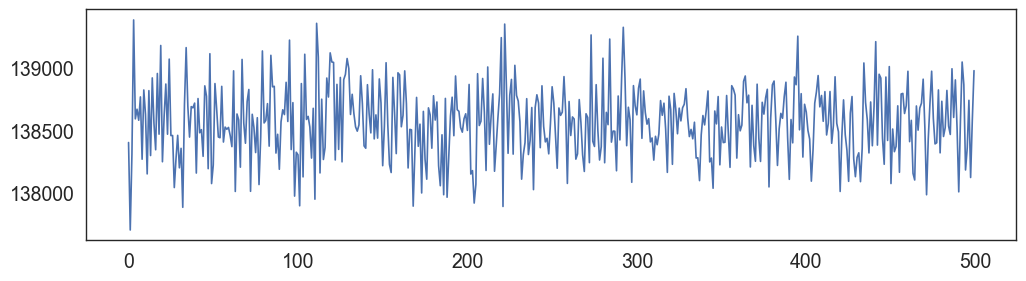

In [ ]:
opts_fitting = opts_fitting | {'state': deepcopy(state), 'params': deepcopy(params)}
opts_regression = opts_regression | {'pruning': 'spike-and-slab'}

rng_key, key = random.split(rng_key)
output = run_inference(key, dense, opts_regression, opts_fitting, train_ds, test_ds, reg_model=BMRRegression)
results['dense']['BMR-S&S'] = output

plt.figure(figsize=(12, 3))
plt.plot(output['losses'][-1])

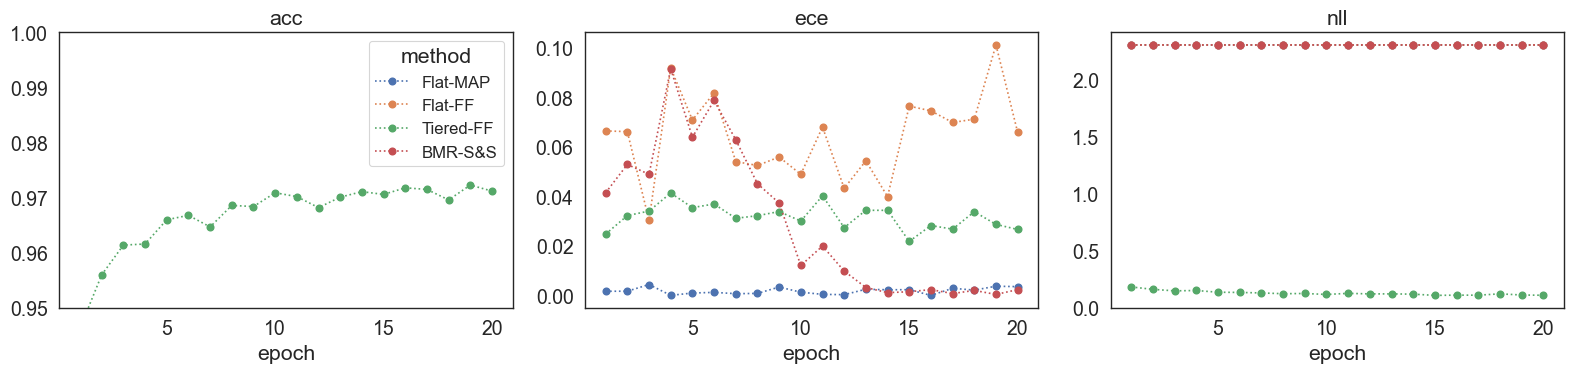

In [ ]:
plot_performance( results['dense'], num_epochs );

## Lie BLR

In [12]:
from  numpyro.infer.autoguide import AutoDelta, AutoNormal
from numpyro.infer.initialization import init_to_median, init_to_uniform

def register_network_latents(nnet, mask, adaptive_scale=True):
    layers = get_linear_layers(nnet)
    L = len(layers)
    new_layers = []
    for l, layer in enumerate(layers):
        name = f'layer{l}'
        weight = layer.weight
        bias = layer.bias
        shape = weight.reshape(weight.shape[0], -1).shape
        if bias is not None:
            shape = (shape[0], shape[1] + 1)

        c_inv_sqr = numpyro.sample(f'{name}.c_inv_sqr', dist.Gamma(2, 6))
        scale = jnp.sqrt( 1 / c_inv_sqr ) if l == L - 1 else jnp.sqrt( 1 / c_inv_sqr ) / 10
        
        _weights = numpyro.sample(name, dist.Normal(0, 1).expand([s for s in shape]).to_event(len(shape)))

        _weights = scale * jnp.where(mask[f'{name}_auto_loc'], _weights, 0.) if mask is not None else scale * _weights
        
        weight = _weights.reshape(weight.shape) if bias is None else _weights[..., :-1].reshape(weight.shape)
        bias = _weights[..., -1].reshape(bias.shape) if bias is not None else bias

        layer = eqx.tree_at(lambda x: (x.weight, x.bias), layer, (weight, bias))
        new_layers.append(layer)
    
    return eqx.tree_at(get_linear_layers, nnet, new_layers)

def likelihood_loc(nnet, x, y, batch_size=None):
    N = x.shape[0]
    with numpyro.plate('data', N, subsample_size=batch_size):
        batch_x = numpyro.subsample(x, event_dim=3)
        key = random.PRNGKey(0) if numpyro.prng_key() is None else numpyro.prng_key()
        keys = random.split(key, batch_x.shape[0]) 
        logits = vmap(nnet)(batch_x, key=keys)

        batch_y = y if y is None else numpyro.subsample(y, event_dim=0)
        
        numpyro.deterministic('probs', nn.softmax(logits, -1))
        numpyro.sample('obs', dist.Categorical(logits=logits), obs=batch_y)

def lifted_model(nnet, x, y=None, batch_size=None, mask=None, adaptive_scale=True):

    nnet = register_network_latents(nnet, mask, adaptive_scale=adaptive_scale)
    likelihood_loc(nnet, x, y, batch_size)

train_set_size = len(train_ds['image'])
scaled_model = numpyro.handlers.scale(lifted_model, scale=1/train_set_size)
auto_delta = AutoDelta(lifted_model, init_loc_fn=lambda site=None: init_to_uniform(site=site, radius=.5))
auto_normal = numpyro.handlers.scale(AutoNormal(lifted_model), scale=1/train_set_size)

In [13]:
def del_f(mu, sigma, sigma0=1.):
    return jnp.log(sigma0/sigma) - 0.5 * mu ** 2 / sigma ** 2

def train_and_test(rng_key, optim, model, guide, num_epochs, num_iters, test_ds, *args, prune=False, progress_bar=False, num_samples=100, **kwargs):
    loss = Trace_ELBO()
    svi = SVI(model, guide, optim, loss)
    rng_key, key = random.split(rng_key)
    state = svi.init(key, *args, **kwargs)
    params = svi.get_params(state)
    mask = jtu.tree_map(lambda x: True, params)

    losses = []
    results = {'acc': [], 'ece': [], 'nll': [], 'lpd': []}
    det_nnet = eqx.tree_inference(args[0], value=True)

    y = kwargs.pop('y')
    batch_size = kwargs.pop('batch_size')

    for epoch in range(num_epochs):
        key, _key = random.split(key)
        kwargs = kwargs | {'mask': mask}
        svi_out = svi.run(
            _key, 
            num_iters,
            *args,
            progress_bar=progress_bar,
            init_state=state,
            init_params=params,
            y=y,
            batch_size=batch_size,
            ** kwargs 
        )

        state = svi_out.state
        params = state.optim_state[1][0]
        losses.append( svi_out.losses )

        noise = state.optim_state[1][1].noise
        A = state.optim_state[1][1].A
        names = list(params.keys())
        key, _key = random.split(key)
        keys = list(random.split(_key, len(names)))
        keys = {name: key for name, key in zip(names, keys) }
        smpl = jtu.tree_map(lambda b, a, key: b + a * noise * random.normal(key, shape=(num_samples, *b.shape)), params, A, keys)
        smpl = {k.split('_')[0]: v for k, v in smpl.items()}
        mdl = partial(numpyro.handlers.substitute(model, params), det_nnet, **kwargs)

        key, _key = random.split(key)
        tmp = Predictive(mdl, posterior_samples=smpl)(_key, test_ds['image'], y=test_ds['label'])
        tmp.pop('obs')
        smpl = smpl | tmp
        
        output = tests(mdl, smpl, test_ds['image'], test_ds['label'])
        for label in results:
            results[label].append(output[label])
        
        if prune and epoch < num_epochs - 1:
            noise = state.optim_state[1][1].noise
            A = state.optim_state[1][1].A
            sigmas = jtu.tree_map(lambda a: noise * a, A)
            mu = params
            mask = jtu.tree_map(lambda m, s, t: t * (del_f(m, s) <= 0), mu, sigmas, mask)

    results['losses'] = losses
    results['mask'] = mask

    return results, rng_key, params, state

def train_and_test_normal(rng_key, optim, model, guide, num_epochs, num_iters, test_ds, *args, progress_bar=False, num_samples=100, num_particles=8, **kwargs):
    loss = TraceMeanField_ELBO(num_particles=num_particles)
    svi = SVI(model, guide, optim, loss)
    rng_key, key = random.split(rng_key)
    state = svi.init(key, *args, **kwargs)
    params = svi.get_params(state)
    mask = jtu.tree_map(lambda x: True, params)

    losses = []
    results = {'acc': [], 'ece': [], 'nll': [], 'lpd': []}
    det_nnet = eqx.tree_inference(args[0], value=True)

    y = kwargs.pop('y')
    batch_size = kwargs.pop('batch_size')

    for epoch in range(num_epochs):
        key, _key = random.split(key)
        kwargs = kwargs | {'mask': mask}
        svi_out = svi.run(
            _key, 
            num_iters,
            *args,
            progress_bar=progress_bar,
            init_state=state,
            init_params=params,
            y=y,
            batch_size=batch_size,
            ** kwargs 
        )

        state = svi_out.state
        params = svi_out.params
        losses.append( svi_out.losses )

        key, _key = random.split(key)
        smpl = Predictive(guide, params=params, num_samples=num_samples)(_key, test_ds['image'], y=test_ds['label'])

        key, _key = random.split(key)
        mdl = partial(numpyro.handlers.substitute(model, params), det_nnet, **kwargs)
        tmp = Predictive(mdl, posterior_samples=smpl)(_key, test_ds['image'], y=test_ds['label'])
        tmp.pop('obs')
        smpl = smpl | tmp
        
        output = tests(mdl, smpl, test_ds['image'], test_ds['label'])
        for label in results:
            results[label].append(output[label])

    results['losses'] = losses

    return results, rng_key, params, state

In [14]:
from optim import lieblr

num_particles = 8
rng_key, key = random.split(rng_key)
lie_optim = BLRToNumpyro()(
    lieblr(key=key, learning_rate=1e-1, a2=100., b2=0.999, init_noise=0.1, num_samples=num_particles, train_set_size=train_set_size)
)

In [ ]:
num_epochs = 20
batch_size = 128
num_iters = 500
kwargs = {
    'y': train_ds['label'],
    'batch_size': batch_size,
    'adaptive_scale': True
}

det_nnet = eqx.tree_inference(nnet, value=True)
args2 = (det_nnet, train_ds['image'])

In [ ]:
lieblr_res, rng_key, params, state = train_and_test(
    rng_key, lie_optim, scaled_model, auto_delta, num_epochs, num_iters, test_ds, *args2, prune=True, progress_bar=True, **kwargs
)

100%|██████████| 500/500 [00:06<00:00, 75.66it/s, init loss: 1.0986, avg. loss [476-500]: 1.0372] 


In [ ]:
lieblr_res2, rng_key, params, state = train_and_test(
    rng_key, lie_optim, scaled_model, auto_delta, num_epochs, num_iters, test_ds, *args2, prune=False, progress_bar=True, **kwargs
)

100%|██████████| 500/500 [00:06<00:00, 75.51it/s, init loss: 1.4147, avg. loss [476-500]: 1.2628] 


In [ ]:
from numpyro.optim import optax_to_numpyro
adam_optim = optax_to_numpyro(optax.adabelief(learning_rate=1e-2))
optax_res, rng_key, params, state = train_and_test_normal(
    rng_key, adam_optim, scaled_model, auto_normal, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs
)

100%|██████████| 500/500 [00:06<00:00, 82.09it/s, init loss: 0.3065, avg. loss [476-500]: 0.2872] 


In [18]:
from numpyro.optim import optax_to_numpyro

learning_rate = 1e-2

optimizer3 = optax_to_numpyro( optax.adam(learning_rate=learning_rate) )
optimizer4 = optax_to_numpyro( optax.adamw(learning_rate=learning_rate) )
optimizer5 = optax_to_numpyro( optax.adabelief(learning_rate=learning_rate) )
optimizer6 = optax_to_numpyro( optax.lion(learning_rate=learning_rate / 10) )

In [ ]:
num_epochs = 20
batch_size = 128
num_iters = 500
kwargs = {
    'y': train_ds['label'],
    'batch_size': batch_size
}

args1 = (nnet, train_ds['image'])

det_nnet = eqx.tree_inference(nnet, value=True)
args2 = (det_nnet, train_ds['image'])

results_all = {}

In [ ]:
results_all['adam'], rng_key, _, _ = train_and_test_delta(optimizer3, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 143.07it/s, init loss: 0.0614, avg. loss [476-500]: 0.0284]


In [ ]:
results_all['adamw'], rng_key, _, _ = train_and_test_delta(optimizer4, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 142.53it/s, init loss: 0.0245, avg. loss [476-500]: 0.0273]


In [ ]:
results_all['adabelief'], rng_key, _, _ = train_and_test_delta(optimizer5, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 147.11it/s, init loss: 0.0191, avg. loss [476-500]: 0.0252]


In [ ]:
results_all['lion'], rng_key, _, _ = train_and_test_delta(optimizer6, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 151.97it/s, init loss: 0.0072, avg. loss [476-500]: 0.0120]


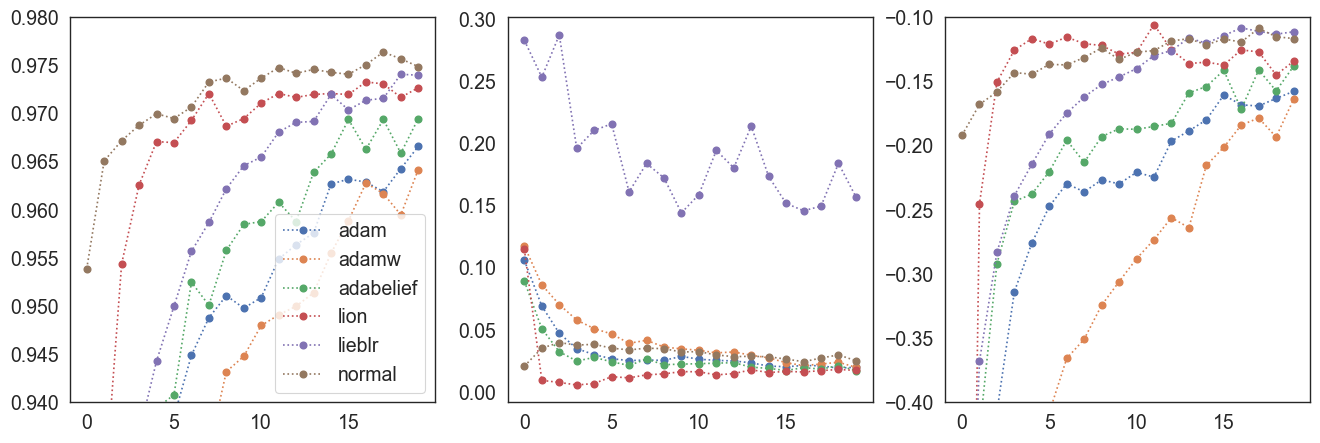

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for method in results_all:
    axes[0].plot(results_all[method]['acc'], 'o:', label=method)
    axes[1].plot(results_all[method]['ece'], 'o:')
    axes[2].plot(results_all[method]['lpd'], 'o:')

for data, label in zip([lieblr_res, optax_res], ['lieblr', 'normal']):
    axes[0].plot( data['acc'], 'o:', label=label)
    axes[1].plot( data['ece'], 'o:' )
    axes[2].plot( data['lpd'], 'o:' )

axes[0].legend()
axes[0].set_ylim([.94, .98]);
axes[2].set_ylim([-.4, -.1]);

## LeNet

In [15]:
train_ds['image'] = jnp.pad(train_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))
test_ds['image'] = jnp.pad(test_ds['image'].transpose(0, 3, 1, 2), ((0, 0), (0, 0), (2, 2), (2, 2)))

in_size = train_ds['image'].shape[-3:]

print(in_size)

rng_key, key = random.split(rng_key)
lenet = LeNet(in_size, activation=nn.tanh, dropout_rate=0.5, key=key)

(1, 32, 32)


In [16]:
num_epochs = 10
batch_size = 128
num_iters = 500
kwargs = {
    'y': train_ds['label'],
    'batch_size': batch_size
}

args1 = (lenet, train_ds['image'])

det_lenet = eqx.tree_inference(lenet, value=True)
args2 = (det_lenet, train_ds['image'])

results_all = {}

In [19]:
results_all['adam'], rng_key, _, _ = train_and_test_delta(optimizer3, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 144.82it/s, init loss: 0.0238, avg. loss [476-500]: 0.0199]


In [20]:
results_all['adamw'], rng_key, _, _ = train_and_test_delta(optimizer4, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

100%|██████████| 500/500 [00:03<00:00, 137.07it/s, init loss: 0.0181, avg. loss [476-500]: 0.0158]


In [21]:
results_all['adabelief'], rng_key, _, _ = train_and_test_delta(optimizer5, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:03<00:00, 139.72it/s, init loss: 0.0287, avg. loss [476-500]: 0.0214]


In [22]:
results_all['lion'], rng_key, _, _ = train_and_test_delta(optimizer6, rng_key, num_epochs, num_iters, test_ds, *args2, progress_bar=True, **kwargs);

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:03<00:00, 145.62it/s, init loss: 0.0058, avg. loss [476-500]: 0.0087]


In [23]:
adam_optim = optax_to_numpyro(optax.adabelief(learning_rate=learning_rate))
results_all['svi-mf'], rng_key, _, _ = train_and_test_normal(
    rng_key, adam_optim, scaled_model, auto_normal, num_epochs, num_iters, test_ds, *args2, num_particles=1, num_samples=64, progress_bar=True, **kwargs
)

100%|██████████| 500/500 [00:05<00:00, 95.51it/s, init loss: 0.3713, avg. loss [476-500]: 0.3620] 


In [24]:
num_particles = 1
lie_optim = BLRToNumpyro()(
    lieblr(key=key, learning_rate=1.0, a2=1e1, init_noise=0.1, num_samples=num_particles, train_set_size=train_set_size)
)

auto_delta = AutoDelta(lifted_model, init_loc_fn=lambda site=None: init_to_uniform(site=site, radius=1.0))

results_all[f'lieblr'], rng_key, _, _ = train_and_test(
    rng_key, lie_optim, scaled_model, auto_delta, num_epochs, num_iters, test_ds, *args2, prune=False, progress_bar=True, num_samples=64, **kwargs
)

100%|██████████| 500/500 [00:04<00:00, 105.22it/s, init loss: 1.2949, avg. loss [476-500]: 1.2306]


In [25]:
results_all['lieblr-bmr'], rng_key, _, _ = train_and_test(
    rng_key, lie_optim, scaled_model, auto_delta, num_epochs, num_iters, test_ds, *args2, prune=True, progress_bar=True, num_samples=64, **kwargs
)

100%|██████████| 500/500 [00:04<00:00, 106.95it/s, init loss: 1.2760, avg. loss [476-500]: 1.1940]


In [28]:
jtu.tree_map(lambda x: x.mean(), results_all['lieblr-bmr']['mask'])

{'layer0.c_inv_sqr_auto_loc': Array(1., dtype=float32),
 'layer0_auto_loc': Array(0.6282051, dtype=float32),
 'layer1.c_inv_sqr_auto_loc': Array(1., dtype=float32),
 'layer1_auto_loc': Array(0.49213576, dtype=float32),
 'layer2.c_inv_sqr_auto_loc': Array(1., dtype=float32),
 'layer2_auto_loc': Array(0.47121778, dtype=float32),
 'layer3.c_inv_sqr_auto_loc': Array(1., dtype=float32),
 'layer3_auto_loc': Array(0.48051947, dtype=float32),
 'layer4.c_inv_sqr_auto_loc': Array(1., dtype=float32),
 'layer4_auto_loc': Array(0.58823526, dtype=float32)}

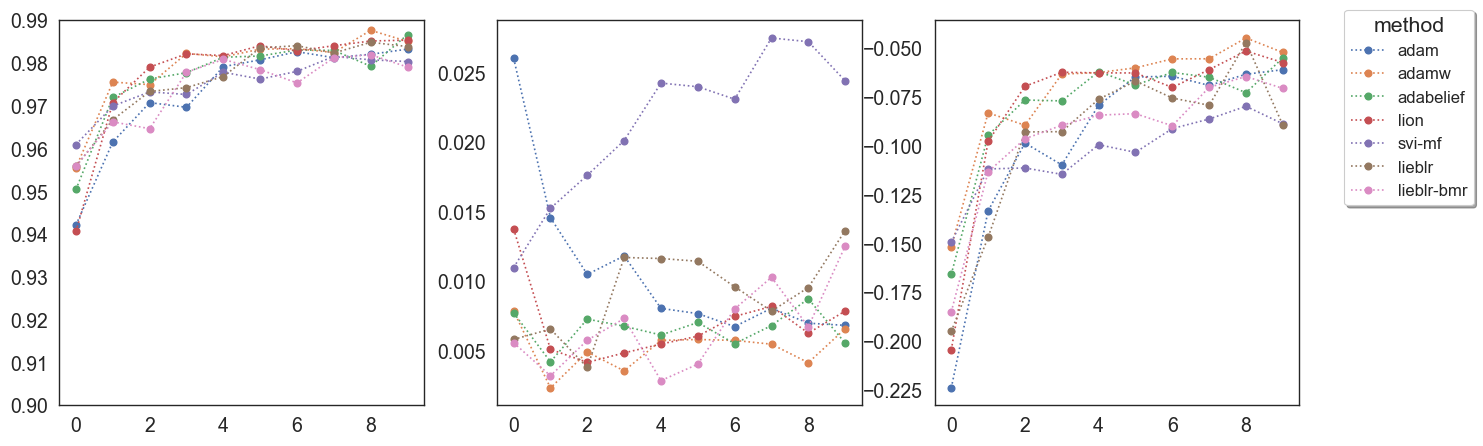

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for method in results_all:
    axes[0].plot(results_all[method]['acc'], 'o:')
    axes[1].plot(results_all[method]['ece'], 'o:')
    axes[2].plot(results_all[method]['lpd'], 'o:', label=method)

axes[-1].legend(bbox_to_anchor=(1.1, 1.05), fancybox=True, shadow=True, title='method', fontsize=12)
axes[0].set_ylim([.9, .99]);

In [ ]:
# Lie-BLR could perform better - implement also other alorithms that were discussed like VON, and the one with quadratic correction so that precision remains positive.
# Try to get improvements in terms of speed.

#TODO: 
# 1. check out the alternative algorithms and try implementing them.
# Particularly, we can turn precision update into unconstrained optimization 
# and used BBVI for updating.
# https://arxiv.org/pdf/1906.02506.pdf
# https://arxiv.org/pdf/2107.04562.pdf
# https://proceedings.mlr.press/v80/khan18a/khan18a.pdf

# 2. write completly custom training-loss functionality without dependence on numpyro 
# and implement optimization algorithms in optax syntax.